In [11]:
import math
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.interpolate as interp1d
import matplotlib.pyplot as plt

def _parse_if_number(s):
    try: return int(s)
    except:
        try: return float(s)
        except: return True if s=="true" else False if s=="false" else s if s else None

df = pd.read_csv('General.csv', converters = {'value': _parse_if_number})

def _split_by_types(df, types):
    result = list()
    for t in types:
        mask = df['type'] == t
        result.append(df[mask])
        df = df[~mask]
    result.append(df)
    return result

itervars, runattrs, configs, attrs, df = _split_by_types(df, ["itervar", "runattr", "config", "attr"])

def _append_metadata_columns(df, meta, suffix):
    meta = pd.pivot_table(meta, index="run", columns="attrname", values="attrvalue", aggfunc="first")

    if not meta.empty:
        df = df.join(meta, on="run", rsuffix=suffix)
    return df

df = _append_metadata_columns(df, itervars, "_itervar")

del attrs, configs, itervars, runattrs
df = df[['value', 'lambda']]

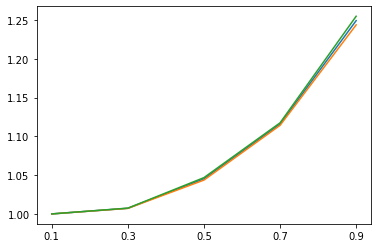

In [19]:
def bootstrap_ci(values): 
    alpha = 0.95
    n = 100
    B = 10000
    np.random.seed(42)
    sample_mean = []
    for _ in range(B): 
        sample_n = np.random.choice(values, size=n)
        sample_mean.append(sample_n.mean())
    mean = np.mean(sample_mean)
    lower_ci = np.percentile(sample_mean, 100*(1-alpha))
    upper_ci = np.percentile(sample_mean, 100*(alpha))
    return { 'mean': mean, 'lower_ci': lower_ci, 'upper_ci': upper_ci }

bs_df = pd.pivot_table(df, values="value", index="lambda", aggfunc=[bootstrap_ci], dropna=False)
bs_xs = bs_df["bootstrap_ci"].index.values
bs_ys = [ x['mean'] for x in bs_df["bootstrap_ci"].value.values]
bs_confint_U = [ x['upper_ci'] for x in bs_df["bootstrap_ci"].value.values]
bs_confint_L = [ x['lower_ci'] for x in bs_df["bootstrap_ci"].value.values]

plt.plot(bs_xs, bs_ys)
plt.plot(bs_xs, bs_confint_L, bs_confint_U)

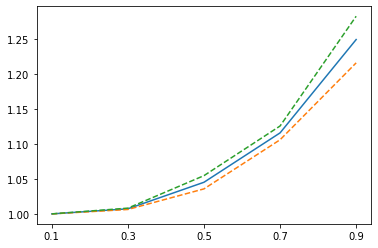

In [21]:
plt.figure()

def mean(values): 
    return np.mean(values)

def confint(values): 
    return st.norm.interval(0.95, loc=0, scale=st.sem(values))[1] if len(values) > 1 else math.nan

normal_df = pd.pivot_table(df, values="value", index="lambda", aggfunc=[mean, confint], dropna=False)
xs = normal_df["mean"].index.values
ys = normal_df["mean"]["value"].values
confint_U = normal_df["confint"]["value"].values
confint_L = normal_df["confint"]["value"].values

plt.plot(xs, ys)
plt.plot(xs,ys-confint_L, ys+confint_U, linestyle='dashed')